# Sentiment Classification

In [1]:
# Import necessary packages
import re
import os
import json
import logging

logging.basicConfig(
    filename='info.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

from os.path import join
import numpy as np
import nltk
from nltk import bigrams
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torch.utils.data import Dataset, DataLoader
import transformers

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sleepyard\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sleepyard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sleepyard\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Define test sets
trainset = 'twitter-training-data.txt'
devset = 'twitter-dev-data.txt'
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']
glove_file = 'glove.6B.100d.txt'

In [3]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'negative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    f1_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        f1_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            f1_by_class[gt]['tp'] += 1
        else:
            f1_by_class[gt]['fn'] += 1
            f1_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in f1_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + ')')
    avgrec = sum(float(acc['tp'] / (acc['tp'] + acc['fn'])) for _, acc in f1_by_class.items()) / 3
    print('Accuracy: %.3f,' % float(ok / len(id_gts)),
        'Average Recall: %.3f,' % avgrec,
        'Macro F1: %.3f' % semevalmacrof1
    )

#### Preprocessing

In [4]:
# The preprocessor
def preprocess(tweet):
    # Remove RT (retweet)
    tweet = re.sub(r"\bRT\b", "", tweet)
    # Replace consecutive dots (...) with whitespace
    tweet = re.sub(r"[.\-']{2,}", " ", tweet)
    # Covert to lower case
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub((r"((https?|ftp)://)?"
            r"[a-z0-9\-._~:/?#\[\]@!$&'()*+,;=%]+"
            r"\.[a-z]{2,}"
            r"[a-z0-9\-._~:/?#\[\]@!$&'()*+,;=%]*"
        ), "", tweet)
    # Remove user Mentions
    tweet = re.sub(r"@[\S]+", "", tweet)
    # Remove hashtags
    tweet = re.sub(r"#[\S]+", "", tweet)
    # Remove non-alphanumeric symbols (keep .'-:,)
    tweet = re.sub(r"[^a-z0-9.'\-:,/\s]", "", tweet)
    # Keep .'- if they are inside a word (between letters)
    tweet = re.sub(r"(?<![a-z])[.\-']|[.\-'](?![a-z])", " ", tweet)
    # Keep :, if they are inside a number (between digits)
    tweet = re.sub(r"(?<![0-9])[:,/]|[:,/](?![0-9])", " ", tweet)
    # Replace multiple whitespaces with one
    tweet = re.sub(r"\s+", " ", tweet)
    # Remove whitespaces at the beginning or end
    tweet = tweet.strip()
    return tweet

In [5]:
# Test the preprocessor
example_tweet_1 = "Yep and that might b my move in Dallas tonight \
RT @AntwannetteBond: True! Tht would b fun.. @Breedlove_08"
example_tweet_2 = "Hmmmmm where are the #BlackLivesMatter when matters like this a rise... \
kids are a disgrace!! https://t.co/aPrB0VtvCN"
example_tweet_3 = "@Talk2Cleo @KerryMacuska That's right, ladies. \
I'm blaming everything on Kerry. Cleo this show may well eclipse the numbers of @JakeNeedham"
example_tweet_4 = "@channelstv: The U.S. says the Boko Haram sect in north-east Nigeria \
may have benefitted from money gotten from crude oil theft."

print(preprocess(example_tweet_1))
print(preprocess(example_tweet_2))
print(preprocess(example_tweet_3))
print(preprocess(example_tweet_4))

yep and that might b my move in dallas tonight true tht would b fun
hmmmmm where are the when matters like this a rise kids are a disgrace
that's right ladies i'm blaming everything on kerry cleo this show may well eclipse the numbers of
the u.s says the boko haram sect in north-east nigeria may have benefitted from money gotten from crude oil theft


In [6]:
# Load training set, dev set and testing set
tweetids = {}
tweetgts = {}
tweets = {}

for dataset in [trainset, devset] + testsets:
    tweets[dataset] = []
    tweetids[dataset] = []
    tweetgts[dataset] = []

    # write code to read in the datasets here
    dataset_path = join('semeval-tweets', dataset)
    with open(dataset_path, 'r', encoding='utf-8') as fh:
        for line in fh:
            fields = line.strip().split('\t')
            tweet_id = fields[0]
            sentiment = fields[1]
            tweet_text = preprocess(fields[2])

            tweetids[dataset].append(tweet_id)
            tweetgts[dataset].append(sentiment)
            tweets[dataset].append(tweet_text)

In [7]:
# Take a look
for dataset in [trainset, devset] + testsets:
    print("-" * 50)
    print(f"{dataset}: {len(tweets[dataset])} tweets" )
    print("tweet:", tweets[dataset][0])
    print("id:", tweetids[dataset][0])
    print("sentiment:", tweetgts[dataset][0])

--------------------------------------------------
twitter-training-data.txt: 45101 tweets
tweet: felt privileged to play foo fighters songs on guitar today with one of the plectrums from the gig on saturday
id: 335104872099066692
sentiment: positive
--------------------------------------------------
twitter-dev-data.txt: 2000 tweets
tweet: hey you i'm gonna be in dublin in february know what i'm saying
id: 262696992176304465
sentiment: neutral
--------------------------------------------------
twitter-test1.txt: 3531 tweets
tweet: candids heading to the chateau marmont in west hollywood october 10th
id: 163361196206957578
sentiment: neutral
--------------------------------------------------
twitter-test2.txt: 1853 tweets
tweet: anybody going to that 4th of july pool party in knollwood
id: 364323072843019872
sentiment: neutral
--------------------------------------------------
twitter-test3.txt: 2379 tweets
tweet: yeah dont think 8 or 9 like some is a risk but welbeck must be amongst t

#### Feature Extraction

Extracting the bag-of-word features and the word-embedding-based features.

##### Bag-of-word

In [9]:
# For bag-of-words, we remove the stop words and perform lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to Noun if not one of the above

# Turn each tweet into a list of lemmatized words
tweetwords = {}
# A vocabulary of words from training set
vocabulary = []

for dataset in [trainset, devset] + testsets:
    tweetwords[dataset] = []

    for tweet in tweets[dataset]:
        words = word_tokenize(tweet)
        tagged_words = pos_tag(words)
        words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos_tag)) \
            for word, pos_tag in tagged_words \
                if word.strip(".-'") not in stop_words]
        tweetwords[dataset].append(words)
    
        if dataset == trainset:
            vocabulary.extend(words)

In [10]:
# Take a look
for dataset in [trainset, devset] + testsets:
    print(f"{dataset}:" )
    print("words:", tweetwords[dataset][0])

twitter-training-data.txt:
words: ['felt', 'privilege', 'play', 'foo', 'fighter', 'song', 'guitar', 'today', 'one', 'plectrum', 'gig', 'saturday']
twitter-dev-data.txt:
words: ['hey', 'gon', 'na', 'dublin', 'february', 'know', 'say']
twitter-test1.txt:
words: ['candids', 'head', 'chateau', 'marmont', 'west', 'hollywood', 'october', '10th']
twitter-test2.txt:
words: ['anybody', 'go', '4th', 'july', 'pool', 'party', 'knollwood']
twitter-test3.txt:
words: ['yeah', 'dont', 'think', '8', '9', 'like', 'risk', 'welbeck', 'must', 'amongst', 'goal', 'delph', 'get', 'knock', 'rest', 'sunday']


In [11]:
vocab = Counter(vocabulary)
print(f"The size of vocabulary is {len(vocab)}.")

The size of vocabulary is 34337.


In [12]:
# Discard the words that occurred less than 10 times in the training dataset
filtered_vocab = {key: value for key, value in vocab.items() if value >= 10}

print(f"The size of vocabulary of words that occurred more than 10 times is {len(filtered_vocab)}.")

The size of vocabulary of words that occurred more than 10 times is 5055.


In [13]:
# The bag-of-words representation for each tweet in vector (list) form
tweetbow = {}

for dataset in [trainset, devset] + testsets:
    tweetbow[dataset] = []
    
    for tweetword in tweetwords[dataset]:
        word_counter = Counter(tweetword)
        bow = []
        for word in filtered_vocab.keys():
            if word in word_counter:
                bow.append(word_counter[word])
            else:
                bow.append(0)
        tweetbow[dataset].append(bow)

In [ ]:
# # Save the bag-of-words representation in files...
# for dataset in [trainset, devset] + testsets:
#     if not os.path.exists("bow"):
#         os.makedirs("bow")
#     with open("bow/bow_" + dataset, "w") as file:
#         for bow in tweetbow[dataset]:
#             file.write(" ".join(map(str, bow)) + "\n")

In [ ]:
# # Read them back (this is just in case the jupyter kernel crashed and I lost all variables...
# # and that I do not want to calculate everything from scratch all over again...)
# tweetbow = {}

# for dataset in [trainset, devset] + testsets:
#     tweetbow[dataset] = []

#     with open("bow/bow_" + dataset, "r") as file:
#         for line in file:
#             bow = list(map(int, line.strip().split()))
#             tweetbow[dataset].append(bow)

##### Word Embedding

In [14]:
# For word embedding, keep the stop words and don't perform lemmatization
# Turn each tweet into a list of raw words
tweetraw = {}
# A combined vocabulary of raw words from the training set
vocabularyraw = []

for dataset in [trainset, devset] + testsets:
    tweetraw[dataset] = []

    for tweet in tweets[dataset]:
        words = word_tokenize(tweet)
        tweetraw[dataset].append(words)

        if dataset == trainset:
            vocabularyraw.extend(words)

In [15]:
# Calculate the average length of tweet from each dataset
for dataset in [trainset, devset] + testsets:
    total_length = 0
    max_length = 0
    total_tweets = len(tweetraw[dataset])
    
    for tweet_raw in tweetraw[dataset]:
        total_length += len(tweet_raw)
    
    average_length = total_length / total_tweets
    print(f"Average sentence length on {dataset}: {average_length}")

Average sentence length on twitter-training-data.txt: 17.89718631515931
Average sentence length on twitter-dev-data.txt: 17.7805
Average sentence length on twitter-test1.txt: 18.845086377796658
Average sentence length on twitter-test2.txt: 18.977873718294656
Average sentence length on twitter-test3.txt: 18.884825556956706


In [16]:
# The average length is around 18-19, let's see how many of the tweets are shorter than 30
for dataset in [trainset, devset] + testsets:
    shorter_than = 0
    total_tweets = len(tweetraw[dataset])
    
    for tweet_raw in tweetraw[dataset]:
        if len(tweet_raw) <= 30:
            shorter_than += 1
    
    percentage = shorter_than / total_tweets
    print(f"{percentage} of tweets on {dataset} are shorter than 30 tokens")

# Most of the tweets are included here so we may just set max_length to 30

0.9949668521762267 of tweets on twitter-training-data.txt are shorter than 30 tokens
0.9945 of tweets on twitter-dev-data.txt are shorter than 30 tokens
0.9966015293118097 of tweets on twitter-test1.txt are shorter than 30 tokens
0.9967620075553157 of tweets on twitter-test2.txt are shorter than 30 tokens
0.9962168978562421 of tweets on twitter-test3.txt are shorter than 30 tokens


In [17]:
vocabraw = Counter(vocabularyraw)
print(f"The size of vocabulary is {len(vocabraw)}.")

The size of vocabulary is 39497.


In [18]:
# Loading the GolVe word embedding vectors
def load_glove_vectors(glove_file):
    glove_vectors = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.strip().split()
            word = split_line[0]
            vector = [float(val) for val in split_line[1:]]
            glove_vectors[word] = vector
    return glove_vectors

In [19]:
glove_vectors = load_glove_vectors(glove_file)

In [20]:
# Discard the words that do not exist in our GloVe embedding
filtered_vocabraw = {key: value for key, value in vocabraw.items() if key in glove_vectors.keys()}

print(f"The size of vocabulary of words that exists in GloVe is {len(filtered_vocabraw)}.")

The size of vocabulary of words that exists in GloVe is 31308.


In [ ]:
# # Save the raw vocabulary in file...
# with open('vocabraw.json', 'w') as f:
#     json.dump(filtered_vocabraw, f)

In [ ]:
# # Read it back (this is just in case the jupyter kernel crashed and I lost all variables...
# # and that I do not want to calculate everything from scratch all over again...)
# with open('vocabraw.json', 'r') as f:
#     filtered_vocabraw = json.load(f)

In [21]:
# Building the vocabulary with an index mapping
# Here we only keep words that occurred more than 10 times in the training dataset
embed_vocab = torchtext.vocab.vocab(
    filtered_vocabraw,
    min_freq=10,
    specials=["<unk>", "<pad>"],
)

unk_index = embed_vocab["<unk>"]
pad_index = embed_vocab["<pad>"]

embed_vocab.set_default_index(unk_index)

In [22]:
# Map tokens to reference word index
tweetembed = {}

for dataset in [trainset, devset] + testsets:
    tweetembed[dataset] = []

    for raw in tweetraw[dataset]:
        tweetembed[dataset].append(embed_vocab.lookup_indices(raw))

In [ ]:
# # Save the embedding reference indices in files...
# for dataset in [trainset, devset] + testsets:
#     if not os.path.exists("embed"):
#         os.makedirs("embed")
#     with open("embed/embed_" + dataset, "w") as file:
#         for embed in tweetembed[dataset]:
#             file.write(" ".join(map(str, embed)) + "\n")

In [ ]:
# # Read them back (this is just in case the jupyter kernel crashed and I lost all variables...
# # and that I do not want to calculate everything from scratch all over again...)
# tweetembed = {}

# for dataset in [trainset, devset] + testsets:
#     tweetembed[dataset] = []

#     with open("embed/embed_" + dataset, "r") as file:
#         for line in file:
#             embed = list(map(int, line.strip().split()))
#             tweetembed[dataset].append(embed)

In [23]:
# The embedding layer for our LSTM model
glove_embedding = nn.Embedding(len(embed_vocab), 100, padding_idx=pad_index)

for i, word in enumerate(embed_vocab.get_itos()):
    if word in glove_vectors:
        glove_embedding.weight.data[i] = torch.tensor(glove_vectors[word])

In [24]:
print(f"Embedding matrix shape: {glove_embedding.weight.data.shape}")

Embedding matrix shape: torch.Size([5890, 100])


#### Sentiment Classifiers

##### MaxEnt

In [25]:
# The default 100 iters failed to converge
maxent_bow_model = LogisticRegression(max_iter=1000)
maxent_bow_model.fit(tweetbow[trainset], tweetgts[trainset])

LogisticRegression(max_iter=1000)

In [26]:
# MaxEnt on bag-of-word features
id_preds = {}
ids = tweetids[devset]
preds = maxent_bow_model.predict(tweetbow[devset])
for i in range(len(ids)):
    id_preds[ids[i]] = preds[i]
            
devset_name = devset
devset_path = join('semeval-tweets', devset_name)
confusion(id_preds, devset_path, "MaxEnt")
evaluate(id_preds, devset_path, "bow" + '-' + "MaxEnt")

            positive  negative  neutral
positive    0.688     0.045     0.267     
negative    0.059     0.629     0.311     
neutral     0.228     0.158     0.614     

semeval-tweets\twitter-dev-data.txt (bow-MaxEnt)
Accuracy: 0.640, Average Recall: 0.607, Macro F1: 0.599


##### Naïve Bayes

In [27]:
nb_bow_model = MultinomialNB()
nb_bow_model.fit(tweetbow[trainset], tweetgts[trainset])

MultinomialNB()

In [28]:
# MaxEnt on bag-of-word features
id_preds = {}
ids = tweetids[devset]
preds = nb_bow_model.predict(tweetbow[devset])
for i in range(len(ids)):
    id_preds[ids[i]] = preds[i]
            
devset_name = devset
devset_path = join('semeval-tweets', devset_name)
confusion(id_preds, devset_path, "NaïveBayes")
evaluate(id_preds, devset_path, "bow" + '-' + "NaïveBayes")

            positive  negative  neutral
positive    0.610     0.068     0.323     
negative    0.105     0.540     0.355     
neutral     0.243     0.117     0.640     

semeval-tweets\twitter-dev-data.txt (bow-NaïveBayes)
Accuracy: 0.607, Average Recall: 0.611, Macro F1: 0.602


##### LSTM PyTorch

In [29]:
# Customized Dataset reader
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.tweetgts = tweetgts[self.dataset]
        self.tweetembed = tweetembed[self.dataset]

    def __len__(self):
        return len(self.tweetgts)

    def __getitem__(self, idx):
        gts = self.tweetgts[idx]
        # Map labels to integer values
        if gts == 'neutral':
            label = torch.tensor(0)
        elif gts == 'negative':
            label = torch.tensor(1)
        elif gts == 'positive':
            label = torch.tensor(2)
        else:
            label = torch.tensor(0)
        # Pad the vector representation of tweets to length 30 with (index for) <pad>
        embed = torch.tensor(self.tweetembed[idx][:30], dtype=torch.int64)
        embed = torch.nn.functional.pad(embed, (0, 30-len(embed)), value=pad_index)
        return embed, label

In [30]:
# Loading all the datasets
train_dataset = CustomDataset(trainset)
dev_dataset = CustomDataset(devset)

test_datasets = {}
for testset in testsets:
    test_datasets[testset] = CustomDataset(testset)

In [31]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size)

test_loaders = {}
for testset in testsets:
    test_loaders[testset] = DataLoader(dataset=test_datasets[testset], batch_size=batch_size)

In [32]:
class SentimentLSTM(nn.Module):
    def __init__(self, embedding, embedding_dim,
        hidden_dim, output_dim, n_layers, bidirectional, dropout_rate
    ):
        super().__init__()
        self.embedding = embedding
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
            bidirectional=bidirectional, dropout=dropout_rate, batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, embed):
        embedded = self.dropout(self.embedding(embed))
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        prediction = self.fc(hidden)
        return prediction

In [33]:
embedding_dim = 100
hidden_dim = 100
output_dim = 3
n_layers = 2
bidirectional = True
dropout_rate = 0.5

lstm_model = SentimentLSTM(glove_embedding, embedding_dim,
    hidden_dim, output_dim, n_layers, bidirectional, dropout_rate
)

In [34]:
count_parameters = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)

print(f"The LSTM model has {count_parameters:,} trainable parameters")

The LSTM model has 403,803 trainable parameters


In [35]:
# Initialize the weights for LSTM model
def initialize_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        nn.init.zeros_(model.bias)
    elif isinstance(model, nn.LSTM):
        for name, param in model.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [36]:
lstm_model.apply(initialize_weights)

SentimentLSTM(
  (embedding): Embedding(5890, 100, padding_idx=1)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [37]:
# Setting some parameters and choosing the optimzer, loss function, etc.
learning_rate = 0.001
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = lstm_model.to(device)
criterion = criterion.to(device)

In [38]:
# Train the model
def train_model(model, criterion, optimizer, train_loader, epoch):
    model.train()
    train_loss = 0.0
    count = 0
    predictions = []
    true_labels = []

    for embeds, labels in train_loader:
        embeds = embeds.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(embeds)
        loss = criterion(outputs, labels)

        predictions.extend(outputs.argmax(dim=-1).numpy())
        true_labels.extend(labels.numpy())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * embeds.size(0)
        count += embeds.size(0)

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    macro_f1 = f1_score(true_labels, predictions, average='macro')

    average_loss = train_loss / count
    return average_loss, macro_f1

In [39]:
# Validate the model
def dev_model(model, criterion, dev_loader, epoch):
    model.eval()
    dev_loss = 0.0
    count = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for embeds, labels in dev_loader:
            embeds = embeds.to(device)
            labels = labels.to(device)
            outputs = model(embeds)
            loss = criterion(outputs, labels)

            predictions.extend(outputs.argmax(dim=-1).numpy())
            true_labels.extend(labels.numpy())

            dev_loss += loss.item() * embeds.size(0)
            count += embeds.size(0)
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    macro_f1 = f1_score(true_labels, predictions, average='macro')

    average_loss = dev_loss / count
    return average_loss, macro_f1

In [40]:
def train_dev(model, criterion, optimizer, train_loader, dev_loader, num_epochs, path):
    torch.save(model.state_dict(), path)
    best_f1 = 0.0

    # loss across epochs
    train_loss_history = []
    dev_loss_history = []
    train_f1_history = []
    dev_f1_history = []

    for epoch in range(num_epochs):
        logging.info(f'Training epoch {epoch+1}......')
        train_loss, train_f1 = train_model(model, criterion, optimizer, train_loader, epoch)
        dev_loss, dev_f1 = dev_model(model, criterion, dev_loader, epoch)
        train_loss_history.append(train_loss)
        dev_loss_history.append(dev_loss)
        train_f1_history.append(train_f1)
        dev_f1_history.append(dev_f1)

        logging.info(f"Average training loss: {train_loss}; Macro F1: {train_f1}")
        logging.info(f"Average validation loss: {dev_loss}; Macro F1: {dev_f1}")
            
        # deep copy the model
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            torch.save(model.state_dict(), path)

    # load best model weights
    model.load_state_dict(torch.load(path))

    return model, train_loss_history, dev_loss_history, train_f1_history, dev_f1_history

In [41]:
# Generate predictions
def test_model(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for embeds, _ in test_loader:
            embeds = embeds.to(device)
            outputs = model(embeds)
            for output in list(outputs.argmax(dim=-1)):
                if output == 0:
                    predictions.append('neutral')
                elif output == 1:
                    predictions.append('negative')
                elif output == 2:
                    predictions.append('positive')
                else:
                    predictions.append('neutral')

    return predictions

In [ ]:
# # Training the model (we can see from the convergence plot that
# # though the loss and macro f1 score on training set keeps improving throughout the 50 epochs,
# # on validation set they stopped improving after around 20 epochs,
# # so there may be danger of overfitting, but we choose the one with the best validation f1)

# # Takes about an hour to run on CPU
# # Unquote this block if you want to train the LSTM model from scratch

# lstm_model, train_loss_history, dev_loss_history, train_f1_history, dev_f1_history = \
#     train_dev(lstm_model, criterion, optimizer, train_loader, dev_loader, 50, 'lstm.pt')

In [42]:
lstm_model.load_state_dict(torch.load('lstm.pt'))

<All keys matched successfully>

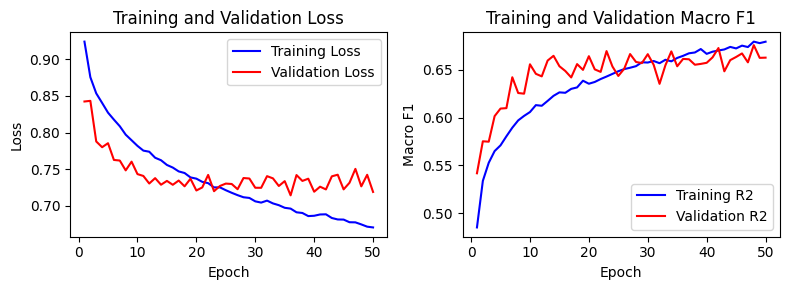

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# axs[0].plot(range(1, len(train_loss_history)+1), train_loss_history, color='blue', label='Training Loss')
# axs[0].plot(range(1, len(dev_loss_history)+1), dev_loss_history, color='red', label='Validation Loss')
# axs[0].set_title('Training and Validation Loss')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Loss')
# axs[0].legend()

# axs[1].plot(range(1, len(train_f1_history)+1), train_f1_history, color='blue', label='Training R2')
# axs[1].plot(range(1, len(dev_f1_history)+1), dev_f1_history, color='red', label='Validation R2')
# axs[1].set_title('Training and Validation Macro F1')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Macro F1')
# axs[1].legend()

# plt.tight_layout()
# plt.show()

In [43]:
id_preds = {}
ids = tweetids[devset]
preds = test_model(lstm_model, dev_loader)
for i in range(len(ids)):
    id_preds[ids[i]] = preds[i]
            
devset_name = devset
devset_path = join('semeval-tweets', devset_name)
confusion(id_preds, devset_path, "LSTM")
evaluate(id_preds, devset_path, "embed" + '-' + "LSTM")

            positive  negative  neutral
positive    0.715     0.051     0.234     
negative    0.078     0.669     0.253     
neutral     0.188     0.130     0.682     

semeval-tweets\twitter-dev-data.txt (embed-LSTM)
Accuracy: 0.691, Average Recall: 0.667, Macro F1: 0.660


##### BERT Transformer

In [44]:
transformer_name = "bert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)
transformer = transformers.AutoModel.from_pretrained(transformer_name)

In [45]:
# Calculate the average length of raw tweet from each dataset
for dataset in [trainset, devset] + testsets:
    total_length = 0
    total_tweets = len(tweets[dataset])
    
    for tweet_raw in tweets[dataset]:
        total_length += len(tokenizer.tokenize(tweet_raw))
    
    average_length = total_length / total_tweets
    print(f"Average sentence length (raw) on {dataset}: {average_length}")

Average sentence length (raw) on twitter-training-data.txt: 20.248974523846478
Average sentence length (raw) on twitter-dev-data.txt: 20.1135
Average sentence length (raw) on twitter-test1.txt: 21.706881903143586
Average sentence length (raw) on twitter-test2.txt: 21.626011872638962
Average sentence length (raw) on twitter-test3.txt: 21.44766708701135


In [46]:
# The average length is around 20-21, let's see how many of the tweets are shorter than 40
# Most of the tweets are included here so we may just set max_length to 40
for dataset in [trainset, devset] + testsets:
    shorter_than = 0
    total_tweets = len(tweets[dataset])
    
    for tweet_raw in tweets[dataset]:
        if len(tokenizer.tokenize(tweet_raw)) <= 40:
            shorter_than += 1
    
    percentage = shorter_than / total_tweets
    print(f"{percentage} of tweets on {dataset} are shorter than 40 tokens")

0.9995787233099044 of tweets on twitter-training-data.txt are shorter than 40 tokens
0.999 of tweets on twitter-dev-data.txt are shorter than 40 tokens
0.9994335882186349 of tweets on twitter-test1.txt are shorter than 40 tokens
0.9994603345925526 of tweets on twitter-test2.txt are shorter than 40 tokens
1.0 of tweets on twitter-test3.txt are shorter than 40 tokens


In [47]:
# Customized Dataset reader FOR BERT
class CustomDatasetBERT(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.tweetgts = tweetgts[self.dataset]
        self.tweets = tweets[self.dataset]

    def __len__(self):
        return len(self.tweetgts)

    def __getitem__(self, idx):
        gts = self.tweetgts[idx]
        # Map labels to integer values
        if gts == 'neutral':
            label = torch.tensor(0)
        elif gts == 'negative':
            label = torch.tensor(1)
        elif gts == 'positive':
            label = torch.tensor(2)
        else:
            label = torch.tensor(0)
        # Pad the vector representation of tweets to length 40 with (index for) <pad>
        encoded_input = tokenizer(self.tweets[idx], padding='max_length', truncation=True, max_length=40)
        embed = torch.tensor(encoded_input['input_ids'], dtype=torch.int64)
        mask = torch.tensor(encoded_input['attention_mask'], dtype=torch.int64)
        return embed, mask, label

In [48]:
# Loading all the datasets
train_datasetBERT = CustomDatasetBERT(trainset)
dev_datasetBERT = CustomDatasetBERT(devset)

test_datasetsBERT = {}
for testset in testsets:
    test_datasetsBERT[testset] = CustomDatasetBERT(testset)

In [49]:
batch_sizeBERT = 32

train_loaderBERT = DataLoader(dataset=train_datasetBERT, batch_size=batch_sizeBERT, shuffle=True)
dev_loaderBERT = DataLoader(dataset=dev_datasetBERT, batch_size=batch_sizeBERT)

test_loadersBERT = {}
for testset in testsets:
    test_loadersBERT[testset] = DataLoader(dataset=test_datasetsBERT[testset], batch_size=batch_sizeBERT)

In [50]:
class SentimentTransformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, embed, mask):
        output = self.transformer(embed, attention_mask=mask, output_attentions=True)
        hidden = output.last_hidden_state
        attention = output.attentions[-1]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        return prediction

In [51]:
transformer_model = SentimentTransformer(transformer, 3, False)

In [52]:
count_parameters = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

print(f"The Transformer model has {count_parameters:,} trainable parameters")

The Transformer model has 109,484,547 trainable parameters


In [53]:
# Setting some parameters and choosing the optimzer, loss function, etc.
learning_rateBERT = 0.00001
optimizerBERT = optim.Adam(transformer_model.parameters(), lr=learning_rateBERT)
criterionBERT = nn.CrossEntropyLoss()
deviceBERT = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = transformer_model.to(deviceBERT)
criterionBERT = criterionBERT.to(deviceBERT)

In [54]:
# Train the model
def train_modelBERT(model, criterion, optimizer, train_loader, epoch):
    model.train()
    train_loss = 0.0
    count = 0
    predictions = []
    true_labels = []
    total_step = len(train_loader)

    for i, (embeds, mask, labels) in enumerate(train_loader):
        embeds = embeds.to(deviceBERT)
        mask = mask.to(deviceBERT)
        labels = labels.to(deviceBERT)
        
        # Forward pass
        outputs = model(embeds, mask)
        loss = criterion(outputs, labels)

        predictions.extend(outputs.argmax(dim=-1).numpy())
        true_labels.extend(labels.numpy())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * embeds.size(0)
        count += embeds.size(0)
        
        if (i+1) % 100 == 0:
            logging.info('Epoch [{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, i+1, total_step, loss.item()))

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    macro_f1 = f1_score(true_labels, predictions, average='macro')

    average_loss = train_loss / count
    return average_loss, macro_f1

In [55]:
# Validate the model
def dev_modelBERT(model, criterion, dev_loader, epoch):
    model.eval()
    dev_loss = 0.0
    count = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for embeds, mask, labels in dev_loader:
            embeds = embeds.to(deviceBERT)
            mask = mask.to(deviceBERT)
            labels = labels.to(deviceBERT)
            outputs = model(embeds, mask)
            loss = criterion(outputs, labels)

            predictions.extend(outputs.argmax(dim=-1).numpy())
            true_labels.extend(labels.numpy())

            dev_loss += loss.item() * embeds.size(0)
            count += embeds.size(0)
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    macro_f1 = f1_score(true_labels, predictions, average='macro')

    average_loss = dev_loss / count
    return average_loss, macro_f1

In [56]:
def train_devBERT(model, criterion, optimizer, train_loader, dev_loader, num_epochs, path):
    torch.save(model.state_dict(), path)
    best_f1 = 0.0

    # loss across epochs
    train_loss_history = []
    dev_loss_history = []
    train_f1_history = []
    dev_f1_history = []

    for epoch in range(num_epochs):
        logging.info(f'Training epoch {epoch+1}......')
        train_loss, train_f1 = train_modelBERT(model, criterion, optimizer, train_loader, epoch)
        dev_loss, dev_f1 = dev_modelBERT(model, criterion, dev_loader, epoch)
        train_loss_history.append(train_loss)
        dev_loss_history.append(dev_loss)
        train_f1_history.append(train_f1)
        dev_f1_history.append(dev_f1)

        logging.info(f"Average training loss: {train_loss}; Macro F1: {train_f1}")
        logging.info(f"Average validation loss: {dev_loss}; Macro F1: {dev_f1}")
            
        # deep copy the model
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            torch.save(model.state_dict(), path)

    # load best model weights
    model.load_state_dict(torch.load(path))

    return model, train_loss_history, dev_loss_history, train_f1_history, dev_f1_history

In [57]:
# Generate predictions
def test_modelBERT(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for embeds, mask, _ in test_loader:
            embeds = embeds.to(deviceBERT)
            mask = mask.to(deviceBERT)
            outputs = model(embeds, mask)
            for output in list(outputs.argmax(dim=-1)):
                if output == 0:
                    predictions.append('neutral')
                elif output == 1:
                    predictions.append('negative')
                elif output == 2:
                    predictions.append('positive')
                else:
                    predictions.append('neutral')

    return predictions

In [ ]:
# # Training the model (we can see from the convergence plot that
# # though the loss and macro f1 score on training set keeps improving throughout the 5 epochs,
# # on validation set they were actually worsening （especially the loss)
# # so there may be danger of overfitting, but we choose the one with the best validation f1)

# # Takes about 18 hours to run on CPU
# # Unquote this block if you want to train the BERT Transformer model from scratch

# transformer_model, train_loss_BERT, dev_loss_BERT, train_f1_BERT, dev_f1_BERT = \
#     train_devBERT(transformer_model, criterionBERT, optimizerBERT, train_loaderBERT, dev_loaderBERT, \
#         5, 'transformer.pt')

In [58]:
transformer_model.load_state_dict(torch.load('transformer.pt'))

<All keys matched successfully>

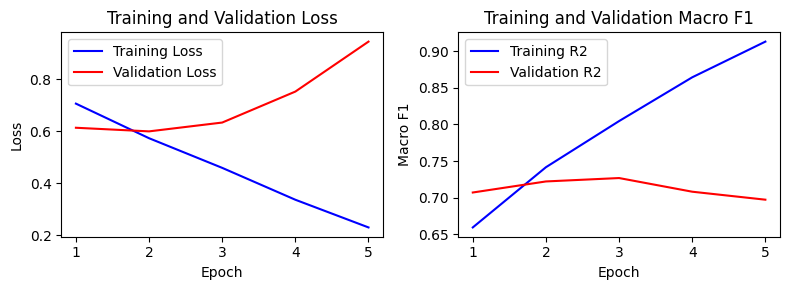

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# axs[0].plot(range(1, len(train_loss_BERT)+1), train_loss_BERT, color='blue', label='Training Loss')
# axs[0].plot(range(1, len(dev_loss_BERT)+1), dev_loss_BERT, color='red', label='Validation Loss')
# axs[0].set_title('Training and Validation Loss')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Loss')
# axs[0].legend()

# axs[1].plot(range(1, len(train_f1_BERT)+1), train_f1_BERT, color='blue', label='Training R2')
# axs[1].plot(range(1, len(dev_f1_BERT)+1), dev_f1_BERT, color='red', label='Validation R2')
# axs[1].set_title('Training and Validation Macro F1')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Macro F1')
# axs[1].legend()

# plt.tight_layout()
# plt.show()

In [59]:
id_preds = {}
ids = tweetids[devset]
preds = test_modelBERT(transformer_model, dev_loaderBERT)
for i in range(len(ids)):
    id_preds[ids[i]] = preds[i]
            
devset_name = devset
devset_path = join('semeval-tweets', devset_name)
confusion(id_preds, devset_path, "BERT Transfomer")
evaluate(id_preds, devset_path, "BERT Transfomer")

            positive  negative  neutral
positive    0.758     0.016     0.227     
negative    0.033     0.711     0.256     
neutral     0.168     0.114     0.717     

semeval-tweets\twitter-dev-data.txt (BERT Transfomer)
Accuracy: 0.731, Average Recall: 0.725, Macro F1: 0.730


#### Evaluation

In [60]:
def get_prediction(classifier, features, testset):
    if classifier == 'MaxEnt':
        preds = maxent_bow_model.predict(tweetbow[testset])
    elif classifier == 'NaïveBayes':
        preds = nb_bow_model.predict(tweetbow[testset])
    elif classifier == 'LSTM':
        test_loader = test_loaders[testset]
        preds = test_model(lstm_model, test_loader)
    elif classifier == 'BERT':
        test_loader = test_loadersBERT[testset]
        preds = test_modelBERT(transformer_model, test_loader)
    
    return preds

In [61]:
# Build traditional sentiment classifiers. An example classifier name 'svm' is given
# in the code below. You should replace the other two classifier names
# with your own choices. For features used for classifier training, 
# the 'bow' feature is given in the code. But you could also explore the 
# use of other features.

for classifier in ['MaxEnt', 'NaïveBayes', 'LSTM', 'BERT']:
    for features in ['bow', 'embed']:
        # Skeleton: Creation and training of the classifiers
        # Sorry but I really don't want to do the training here
        # they are already done in previous code blocks
        if classifier not in ['LSTM', 'BERT']:
            if features == 'embed':
                continue
        elif classifier in ['LSTM', 'BERT']:
            if features != 'embed':
                continue
        print(f"Testing {classifier} classifier with {features} features:")
        print('=' * 55)

        # Predition performance of the classifiers
        for testset in testsets:
            id_preds = {}
            # write the prediction and evaluation code here
            ids = tweetids[testset]
            preds = get_prediction(classifier, features, testset)
            for i in range(len(ids)):
                id_preds[ids[i]] = preds[i]
            
            testset_name = testset
            testset_path = join('semeval-tweets', testset_name)
            # confusion(id_preds, testset_path, classifier)
            evaluate(id_preds, testset_path, features + '-' + classifier)
            print('-' * 55)
        print()

Testing MaxEnt classifier with bow features:
semeval-tweets\twitter-test1.txt (bow-MaxEnt)
Accuracy: 0.632, Average Recall: 0.573, Macro F1: 0.554
-------------------------------------------------------
semeval-tweets\twitter-test2.txt (bow-MaxEnt)
Accuracy: 0.646, Average Recall: 0.573, Macro F1: 0.569
-------------------------------------------------------
semeval-tweets\twitter-test3.txt (bow-MaxEnt)
Accuracy: 0.614, Average Recall: 0.565, Macro F1: 0.536
-------------------------------------------------------

Testing NaïveBayes classifier with bow features:
semeval-tweets\twitter-test1.txt (bow-NaïveBayes)
Accuracy: 0.605, Average Recall: 0.551, Macro F1: 0.546
-------------------------------------------------------
semeval-tweets\twitter-test2.txt (bow-NaïveBayes)
Accuracy: 0.635, Average Recall: 0.537, Macro F1: 0.548
-------------------------------------------------------
semeval-tweets\twitter-test3.txt (bow-NaïveBayes)
Accuracy: 0.597, Average Recall: 0.549, Macro F1: 0.533
-